In [3]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import time

In [9]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [10]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_JF_ON = JF_file[channel_JFimages][:,:,:][reprate_laser]
        image_JF_OFF = JF_file[channel_JFimages][:,:,:][reprate_FEL]
        
        
        pulse_ids_ON = pulse_ids[reprate_laser]
        pulse_ids_OFF = pulse_ids[reprate_FEL]
        
        image_roi1_ON = image_JF_ON[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_ON = image_JF_ON[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
        image_roi1_OFF = image_JF_OFF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_OFF = image_JF_OFF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, pulse_ids_ON, pulse_ids_OFF

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]      
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy, Izero_pump, Izero_unpump

def LoadData_JF_crop(filename):
    with h5py.File(filename, 'r') as JF_file:
        p_ids= JF_file["JF02T09V01_crop/pulse_ids"][:]
 #       p_ids = np.reshape(p_ids, (p_ids.size,)) # .ravel()
        
        reprate_FEL = ((p_ids%4 == 0) & (p_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = p_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_roi1_ON = JF_file["JF02T09V01_crop/roi1"][:,:,:][reprate_laser]
        image_roi1_OFF = JF_file["JF02T09V01_crop/roi1"][:,:,:][reprate_FEL]
        
        image_roi2_ON = JF_file["JF02T09V01_crop/roi2"][:,:,:][reprate_laser]
        image_roi2_OFF = JF_file["JF02T09V01_crop/roi2"][:,:,:][reprate_FEL]
        
        #pulse_ids_ON = pulse_ids[reprate_laser]
        #pulse_ids_OFF = pulse_ids[reprate_FEL]
    
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, p_ids


In [5]:
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)

In [4]:
#Febpy data
DIR = "/das/work/p17/p17803/alvra_beamline_scripts/testSave/"
DIR2 = "/sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"
# !ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/

#Cyt c 288 nm data
#DIR = "/das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/"
#DIR2 = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010/"
#DIR_json = "/sf/alvra/data/p17803/res/scan_info/"
#!ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/

#Cyt c 350 nm data
# DIR = "/das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop/"
# DIR2 = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/"
# DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

#!ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_011_crop/

!ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/testSave/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)

print ("There are",number_files,"files in the folder", DIR)

total 535M
drwxrws---+ 27 cirelli_c p17803  32K May  2 13:45 ..
drwxrws---+  3 cirelli_c p17803 4.0K May  2 13:44 .
-rw-rw----+  1 cirelli_c p17803 268M May  2 13:43 FeBpy_monoscan_350nm_10uJ_100fs_004_crop_28_rotated.h5
drwxr-s---+  2 cirelli_c p17803 4.0K May  2 13:42 .ipynb_checkpoints
-rw-rw----+  1 cirelli_c p17803 268M May  2 13:40 FeBpy_monoscan_350nm_10uJ_100fs_004_crop_28_regular.h5
ra-c-004.psi.ch
There are 3 files in the folder /das/work/p17/p17803/alvra_beamline_scripts/testSave/


In [91]:
fileName = "FeBpy_monoscan_350nm_10uJ_100fs_004_crop_28_regular.h5"
#fileName = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_03.h5"
#fileName = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop_13.h5"
#fileName= "XES_8keV_jet_350nm_500fs_007"

jf_file = h5py.File(DIR+fileName)
imageROI1 = jf_file["JF02T09V01_crop/roi1"]
imageROI2 = jf_file["JF02T09V01_crop/roi2"]
pulse_ids= jf_file["JF02T09V01_crop/pulse_ids"]
h5py.File.close

imageROI1.shape

(2000, 100, 200)

In [92]:
imageROI1_regular = np.copy(imageROI1)

In [94]:
imageROI1_regular[0].ravel()[0:10]

array([-0.34710446,  0.29693836, -0.2836515 , -0.65145576, -0.62576437,
        0.08863389, -0.5447698 ,  0.08944119, -0.14302684, -0.15207696],
      dtype=float32)

In [76]:
imageROI1_rotated[0].ravel()[0:10]

array([-0.34828547,  0.30061048, -0.28340185, -0.65180874, -0.61380357,
        0.08728121, -0.54621905,  0.08834696, -0.14224343, -0.1528134 ],
      dtype=float32)

<IPython.core.display.Javascript object>


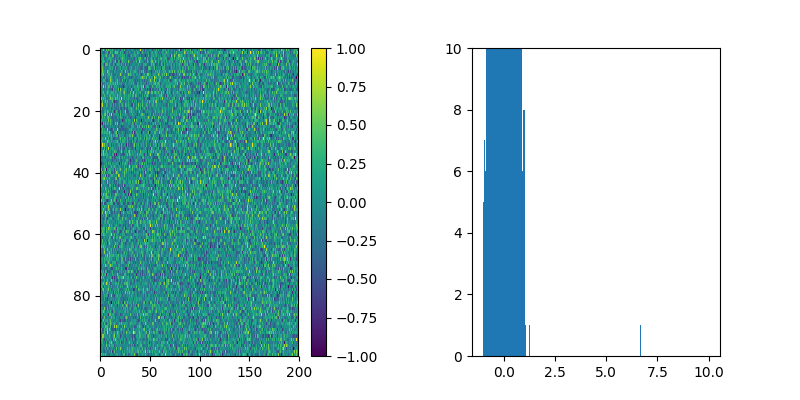

In [80]:
p=1
showfigure=imageROI1_regular[p]

plt.figure(figsize = (8,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.imshow(showfigure, aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

plt.subplot(122)
plt.hist(showfigure.ravel(),250,[-1,10])
plt.ylim((0,10))
plt.show()

# Set Thresholds!

<IPython.core.display.Javascript object>


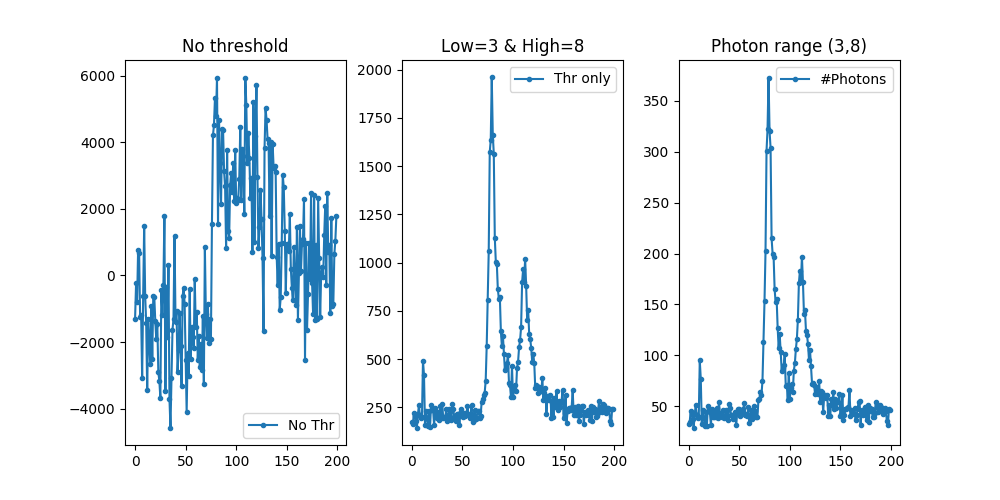

9.182047 8.87391
13.646760326872664 12.430214635260182


In [88]:
total=0
total_thr =0
total_thr_photNum =0

threshold_low = 3
threshold_high = 8
photon_range = (3,8)

nframes =2000
for i in range(nframes):
    image = jf_file["JF02T09V01_crop/roi1"][i][:]
    image_thr = jf_file["JF02T09V01_crop/roi1"][i][:]
    image_thr_photNum = jf_file["JF02T09V01_crop/roi1"][i][:]
    
    image_thr[image_thr < threshold_low] = 0
    image_thr[image_thr > threshold_high] = 0
    
    image_thr_photNum[image_thr_photNum < 0] = 0
    image_thr_photNum = convert_to_photon_num_range(image_thr_photNum)
    
    total += image
    total_thr += image_thr
    total_thr_photNum += image_thr_photNum
    
spectrum_raw = total.sum(axis = 0)
spectrum_thr = total_thr.sum(axis = 0)
spectrum_thr_photNum = total_thr_photNum.sum(axis = 0)


plt.figure(figsize = (10,5))
plt.subplots_adjust(wspace=0.25)

plt.subplot(131)
plt.plot(spectrum_raw, label="No Thr", marker='.')
plt.legend(loc="best")
plt.title("No threshold")

plt.subplot(132)
plt.plot(spectrum_thr, label="Thr only", marker='.')
plt.legend(loc="best")
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))

plt.subplot(133)
plt.plot(spectrum_thr_photNum, label="#Photons", marker='.')
plt.legend(loc="best")
plt.title("Photon range (3,8)")

print (max(spectrum_thr)/(spectrum_thr[20:50].mean()),max(spectrum_thr_photNum)/(spectrum_thr_photNum[20:50].mean()))
print (100*spectrum_thr[20:50].std()/spectrum_thr[20:50].mean(),100*spectrum_thr_photNum[20:50].std()/spectrum_thr_photNum[20:50].mean())

In [89]:
imageROI1_regular[0].ravel()[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<IPython.core.display.Javascript object>


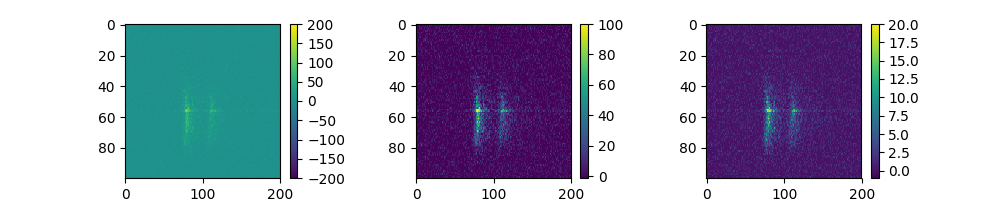

In [71]:
plt.figure(figsize = (10,2))
plt.subplots_adjust(wspace=0.5)

plt.subplot(131)
plt.imshow(total, aspect='auto', vmin=-200, vmax=200)
plt.colorbar()

plt.subplot(132)
plt.imshow(total_thr, aspect='auto', vmin=-1, vmax=100)
plt.colorbar()

plt.subplot(133)
plt.imshow(total_thr_photNum, aspect='auto', vmin=-1, vmax=20)
plt.colorbar()

In [74]:
imageROI1_regular[0].ravel()[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<IPython.core.display.Javascript object>


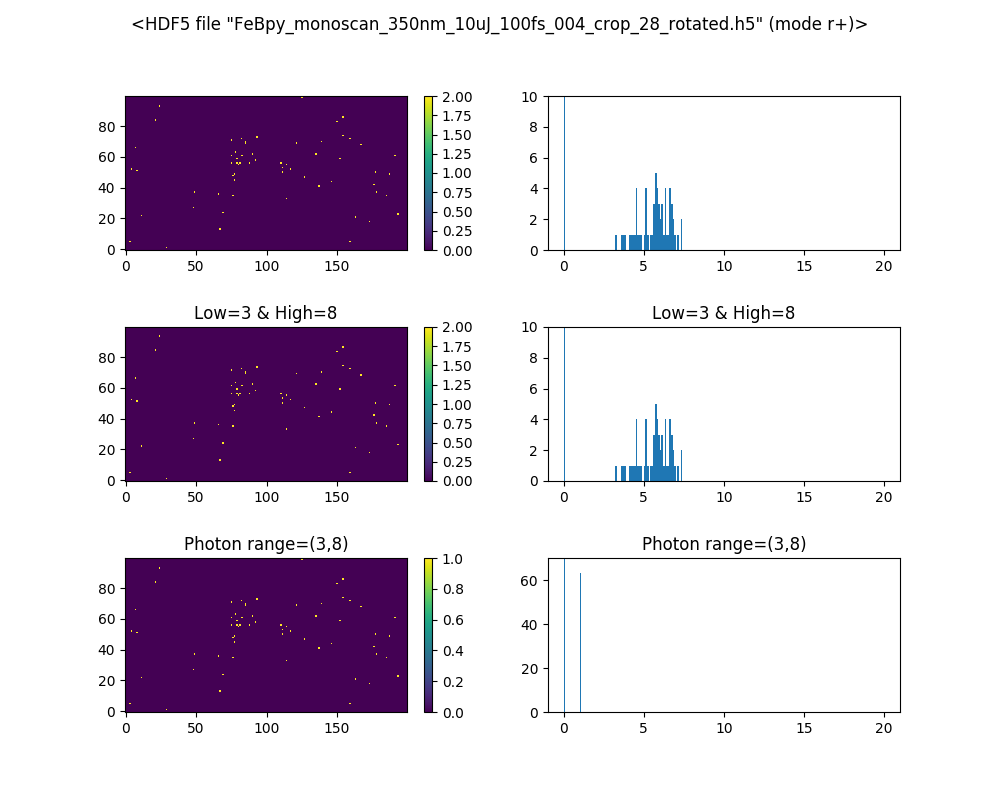

Total counts: only thr= 358.0 , only photon range= 63.0


In [72]:
nframes = 10
total = 0
total_thr = 0
total_thr_photNum = 0

threshold_low = 3
threshold_high = 8
photon_range = (3,8)

for i in range(nframes):
    image = imageROI1_regular[i][:]
    image_thr = imageROI1_regular[i][:]
    image_thr_photNum = imageROI1_regular[i][:]
    
    total = total + image
    
    image_thr[image_thr < threshold_low] = 0
    image_thr[image_thr > threshold_high] = 0
    total_thr = total_thr + image_thr
    
    image_thr_photNum[image_thr_photNum < 0] = 0
    image_thr_photNum = convert_to_photon_num_range(image_thr_photNum)
    total_thr_photNum = total_thr_photNum + image_thr_photNum
    

#total= total/nframes
#total_thr = total_thr/nframes

plt.figure(figsize = (10,8))
plt.suptitle(jf_file, fontsize=12)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(total, origin="lower", aspect='auto', vmin=0.00, vmax=2)
plt.colorbar()

plt.subplot(322)
plt.hist(total.ravel(),200,[0,20])
plt.ylim((0,10))

plt.subplot(323)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0.00, vmax=2)
plt.colorbar()
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))

plt.subplot(324)
plt.hist(total_thr.ravel(),200,[0,20])
plt.ylim((0,10))
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))

plt.subplot(325)
plt.imshow(total_thr_photNum, origin="lower", aspect='auto')#, vmin=0.00, vmax=2)
plt.colorbar()
plt.title("Photon range=(3,8)")
#plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))

plt.subplot(326)
plt.hist(total_thr_photNum.ravel(),200,[0,20])
plt.ylim((0,70))
plt.title("Photon range=(3,8)")

print ("Total counts: only thr=",np.ceil(total_thr.sum()),", only photon range=",total_thr_photNum.sum())

In [73]:
total.ravel()[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [56]:
total.ravel()[0:50]

array([  -6.975839 ,   26.294888 ,  -18.121313 ,  -26.318222 ,
         -7.1296296,  -68.90885  ,  -33.051018 ,  -56.93717  ,
        -80.398705 ,   99.789696 ,   -6.214053 , -185.82172  ,
         -6.581046 ,  -14.342941 ,  -50.569008 ,    6.171204 ,
         -5.330324 ,   37.59277  ,   -6.625    ,  -18.202013 ,
         17.772097 ,   12.235623 ,    4.102507 , -136.8411   ,
        -98.80925  ,   -1.0063387,   35.601974 ,   25.44469  ,
        -51.162323 ,   26.33983  ,  -23.499994 ,  -19.690395 ,
       -163.83476  ,  -31.33559  ,   15.610755 ,  -54.888622 ,
        -61.941273 ,  -23.562805 ,  -98.89084  ,   20.651213 ,
          0.5918999,  -65.95966  ,  -33.31453  , -117.25642  ,
        -14.682604 ,  -19.43408  ,  -21.141212 ,  -79.008865 ,
         68.02606  ,   17.641651 ], dtype=float32)

<IPython.core.display.Javascript object>


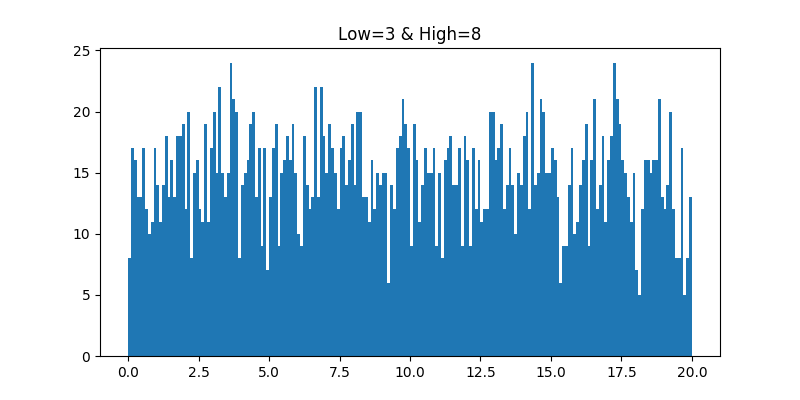

<IPython.core.display.Javascript object>


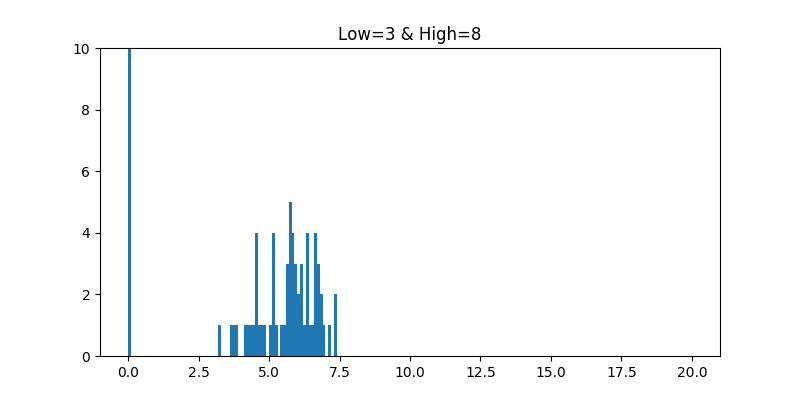

<function matplotlib.pyplot.show>

In [58]:
plt.figure(figsize=(8,4))
plt.plot
plt.hist(total.ravel(),200,[0,20])
#plt.ylim((0,10))
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))
plt.show

plt.figure(figsize=(8,4))
plt.plot
plt.hist(total_thr_rotated.ravel(),200,[0,20])
plt.ylim((0,10))
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))
plt.show



# Next cell is for a single file

In [57]:
threshold_low = 3
threshold_high = 8
photon_range = (3,8)
sigma_low= 1.5
sigma_high= 3.5


files = ["FeBpy_monoscan_350nm_10uJ_500fs_009"]
#files = ["CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010"]
#files = ["CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_012"]

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
image_ON_2D_roi1=0
image_OFF_2D_roi1=0
        
for f in files:
    
    JF_single_file = DIR + f + "_crop_13.h5"
    BS_single_file = DIR2 + f + "_step0013.BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
    (image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF,pids) = LoadData_JF_crop(str(JF_single_file))
    (Delay_mm,Energy_eV,Izero_pump,Izero_unpump) = LoadData_BS(str(BS_single_file))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    nframes_ON = np.ma.size(image_roi1_ON,0)
    nframes_OFF = np.ma.size(image_roi1_OFF,0)
    print (nframes_ON, nframes_OFF,pids[0])
    
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
        image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)#/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
        image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)#/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
        image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)#/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
        image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)#/Izero_unpump[j]
        
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


Processing file /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_13.h5
1000 1000 7760032272
Job done! It took 1.09 seconds to process 1 file(s)


In [58]:
Energy_eV.mean()

7110.534388549446

<IPython.core.display.Javascript object>


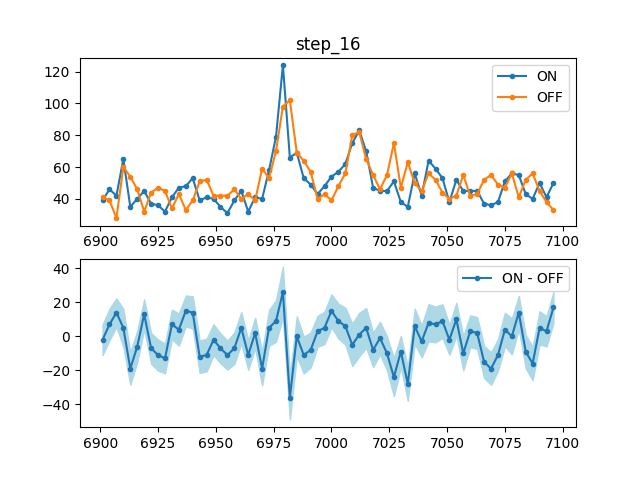

In [59]:
roi1 = [[200, 300], [6900, 7100]]

bin_ = 3   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

low_err_ON = spectra_on_rebin1 - spectra_on_err1
high_err_ON = spectra_on_rebin1 + spectra_on_err1
low_err_OFF = spectra_off_rebin1 - spectra_off_err1
high_err_OFF = spectra_off_rebin1 + spectra_off_err1

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
#plt.fill_between(x_axis_rebin1, low_err_ON, high_err_ON, color='lightblue')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
#plt.fill_between(x_axis_rebin1, low_err_OFF, high_err_OFF, color='lightblue')
plt.legend(loc="best")
plt.title("step_16")

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


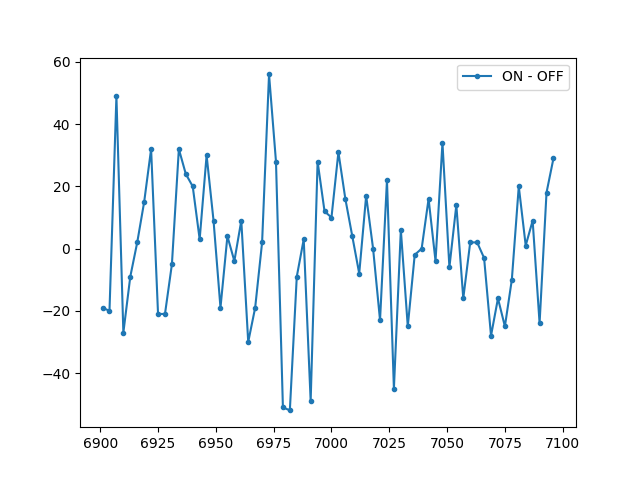

In [62]:
plt.figure()

plt.plot(x_axis_rebin1,spectra_sum, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

# Loop over the cropped files

In [131]:
threshold_low = 3
threshold_high = 8
photon_range = (3,8)
sigma_low= 1.5
sigma_high= 3.5

scan_name = "FeBpy_monoscan_350nm_10uJ_500fs_009"
#scan_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010"
#scan_name = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014"
######################################################################################
start_time = time.time()
intermediate_time = time.time()


Energy_eV = []
Delay_mm = []
XAS_trans_shot2shot = []
XAS_pump = []
XAS_unpump =[]
XAS_trans_roi1 = []
Error_XAS_pump_roi1 = []
Error_XAS_unpump_roi1 = []
XAS_trans_roi2 = []
Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []

DIR_NoScanName = "/das/work/p17/p17803/alvra_beamline_scripts/"
DIR_crop = DIR_NoScanName + scan_name + "_crop/"

listfile_crop = os.listdir(DIR_crop)
numFiles_crop = len(listfile_crop)
print ("Number of cropped files:", numFiles_crop)

json_file = DIR_json + scan_name + "_scan_info.json"
with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
print ("Number of BS files:", numFiles)

#numFiles = 37

for i in range(0,numFiles):
    
    if i < 10:
        JF_crop_file = DIR_crop + scan_name + "_crop_0" + str(i) + ".h5"
    else:
        JF_crop_file = DIR_crop + scan_name + "_crop_" + str(i) + ".h5"   
    print ("step",i+1,"of",numFiles,": Processing", JF_crop_file)
    print ("Processing %s" % (str(data['scan_files'][i][0])))
    
    spectrum_ON_roi1 = 0
    spectrum_ON_roi1_single = 0
    spectrum_OFF_roi1 = 0
    spectrum_OFF_roi1_single = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    image_ON_2D_roi1=0
    image_OFF_2D_roi1=0
    difference_shot2shot_roi1=0
    
    (image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF,pids) = LoadData_JF_crop(str(JF_crop_file))
    (delay_loop,energy_loop,Izero_pump,Izero_unpump) = LoadData_BS(str(data['scan_files'][i][0]))
    
    energy_loop = [x for x in energy_loop if (x > 0)]     #This is to prevent that some occasional zeros screw up the mean value calculated below
    delay_loop = [x for x in delay_loop if (x > 0)]       #This is to prevent that some occasional zeros screw up the mean value calculated below
    Delay_mm.append(np.mean(delay_loop))
    Energy_eV.append(np.mean(energy_loop))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    nframes_ON = np.ma.size(image_roi1_ON,0)
    nframes_OFF = np.ma.size(image_roi1_OFF,0)
    print (nframes_ON, nframes_OFF, pids[0])
    
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
        image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)#/Izero_pump[j]
            spectrum_ON_roi1_single = image_ON_2D_roi1.sum(axis=0)#/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
        image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)#/Izero_unpump[j]
            spectrum_OFF_roi1_single = image_OFF_2D_roi1.sum(axis=0)#/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
        image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)#/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
        image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)#/Izero_unpump[j]
            
        difference_shot2shot_roi1 += spectrum_ON_roi1_single - spectrum_OFF_roi1_single
            
    spectrum_ON_roi1_baseline = spectrum_ON_roi1 - spectrum_ON_roi1[0:5:1].mean()
    spectrum_OFF_roi1_baseline = spectrum_OFF_roi1- spectrum_OFF_roi1[0:5:1].mean()
    difference_roi1 = (spectrum_ON_roi1_baseline - spectrum_OFF_roi1_baseline)
    #difference_roi1 = np.abs(difference_roi1)[70:95:1].sum()
    #difference_roi1 = np.abs(difference_roi1)[75:85:1].sum()
    
    XAS_pump.append(np.abs(spectrum_ON_roi1)[69:100:1].sum())
    XAS_unpump.append(np.abs(spectrum_OFF_roi1)[69:100:1].sum())
    
    XAS_trans_shot2shot.append(np.abs(difference_shot2shot_roi1)[69:100:1].sum())
    XAS_trans_roi1.append(difference_roi1)
    
    error_ON_roi1 = np.sqrt(np.sum(spectrum_ON_roi1[69:100:1]))
    error_OFF_roi1 = np.sqrt(np.sum(spectrum_OFF_roi1[69:100:1]))
    
    Error_XAS_pump_roi1.append(error_ON_roi1)
    Error_XAS_unpump_roi1.append(error_OFF_roi1)
    
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt(np.sqrt(spectrum_ON_roi1)**2 + np.sqrt(spectrum_OFF_roi1)**2))
    
    difference_roi2 = spectrum_ON_roi2.sum() - spectrum_OFF_roi2.sum()
    XAS_trans_roi2.append(difference_roi2)
    error_ON_roi2 = np.sum(np.sqrt(spectrum_ON_roi2))
    error_OFF_roi2 = np.sum(np.sqrt(spectrum_OFF_roi2))
    
    Error_XAS_roi2.append(np.sqrt(error_ON_roi2**2 + error_OFF_roi2**2))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(difference_roi2)
    Error_transient_roi2.append(np.sqrt(np.sqrt(spectrum_ON_roi2)**2 + np.sqrt(spectrum_OFF_roi2)**2))
    
    print ("It took",round((time.time() - intermediate_time),2),"s to process this file")
    intermediate_time = time.time()
    
Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)

XAS_pump = np.array(XAS_pump)
XAS_unpump = np.array(XAS_unpump)
XAS_trans_roi1 = np.array(XAS_trans_roi1)
Error_XAS_pump_roi1 = np.array(Error_XAS_pump_roi1)
Error_XAS_unpump_roi1 = np.array(Error_XAS_unpump_roi1)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)

XAS_trans_roi2 = np.array(XAS_trans_roi2)
Error_XAS_roi2 = np.array(Error_XAS_roi2)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)

print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",numFiles,"file(s)")


Number of cropped files: 30
Number of BS files: 29
step 1 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_00.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/FeBpy_monoscan_350nm_10uJ_500fs_009_step0000.BSREAD.h5
1000 1000 7759919312
It took 1.56 s to process this file
step 2 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_01.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/FeBpy_monoscan_350nm_10uJ_500fs_009_step0001.BSREAD.h5
1000 1000 7759928008
It took 1.61 s to process this file
step 3 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_02.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/Fe

1000 1000 7760127768
It took 1.55 s to process this file
step 25 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_24.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/FeBpy_monoscan_350nm_10uJ_500fs_009_step0024.BSREAD.h5
1000 1000 7760136488
It took 1.51 s to process this file
step 26 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_25.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_009/FeBpy_monoscan_350nm_10uJ_500fs_009_step0025.BSREAD.h5
1000 1000 7760145212
It took 1.56 s to process this file
step 27 of 29 : Processing /das/work/p17/p17803/alvra_beamline_scripts/FeBpy_monoscan_350nm_10uJ_500fs_009_crop/FeBpy_monoscan_350nm_10uJ_500fs_009_crop_26.h5
Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500

<IPython.core.display.Javascript object>


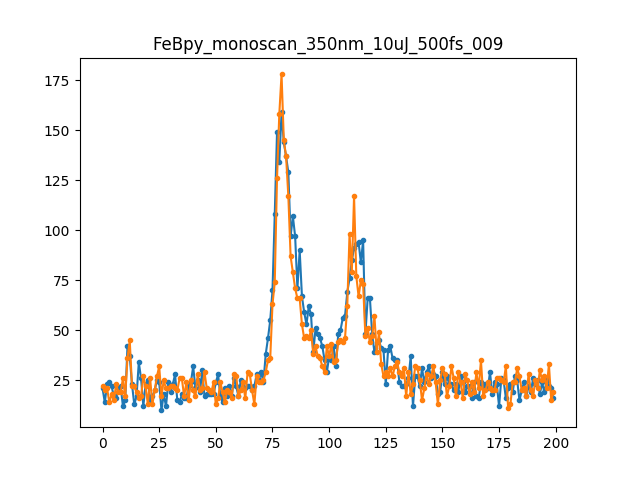

Text(0.5,1,'FeBpy_monoscan_350nm_10uJ_500fs_009')

In [132]:
plt.figure()
plt.plot(spectrum_ON_roi1,label="ON",marker='.')
plt.plot(spectrum_OFF_roi1,label="OFF",marker='.')

plt.title(scan_name)

<IPython.core.display.Javascript object>


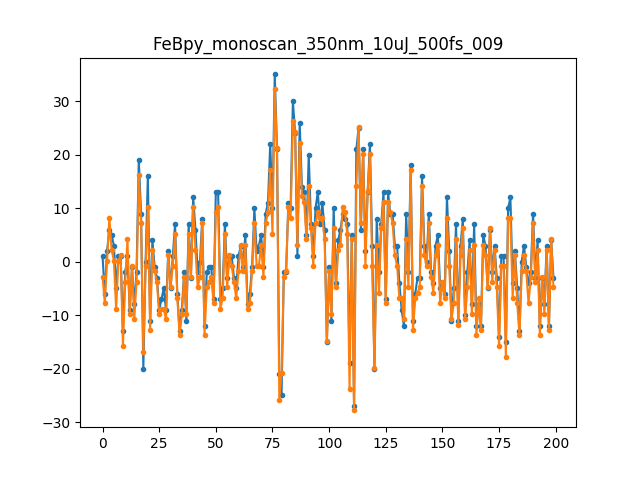

-66.99992 251.0 391.0


In [133]:
plt.figure()
plt.plot(difference_shot2shot_roi1,label="Energy scan",marker='.')
plt.plot(difference_roi1,label="Energy scan",marker='.')

plt.title(scan_name)

print (difference_roi1.sum(), difference_shot2shot_roi1.sum(), XAS_trans_shot2shot[28])

<IPython.core.display.Javascript object>


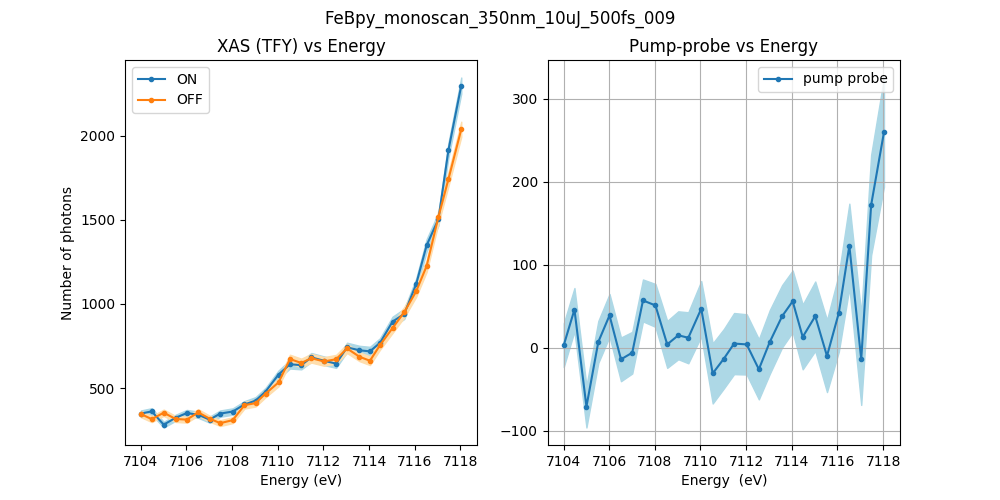

In [134]:
plt.figure(figsize = (10,5))
plt.suptitle(scan_name, fontsize=12)

low_err_pump= XAS_pump - Error_XAS_pump_roi1
high_err_pump= XAS_pump + Error_XAS_pump_roi1
low_err_unpump= XAS_unpump - Error_XAS_unpump_roi1
high_err_unpump= XAS_unpump + Error_XAS_unpump_roi1

low_err_diff= (XAS_pump-XAS_unpump) - np.sqrt(Error_XAS_pump_roi1**2+Error_XAS_unpump_roi1**2)
high_err_diff= (XAS_pump-XAS_unpump) + np.sqrt(Error_XAS_pump_roi1**2+Error_XAS_unpump_roi1**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, XAS_pump,label="ON",marker='.')
plt.plot(Energy_eV, XAS_unpump,label="OFF",marker='.')
plt.fill_between(Energy_eV, low_err_pump, high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, low_err_unpump, high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.ylabel("Number of photons")
plt.gca().set_title('XAS (TFY) vs Energy')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, XAS_pump - XAS_unpump,label="pump probe",marker='.')
plt.fill_between(Energy_eV, low_err_diff, high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")


<IPython.core.display.Javascript object>


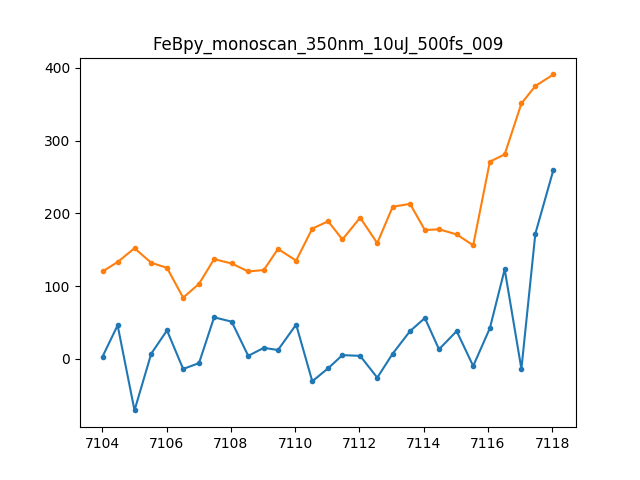

Text(0.5,1,'FeBpy_monoscan_350nm_10uJ_500fs_009')

In [135]:
plt.figure()
plt.plot(Energy_eV, XAS_pump - XAS_unpump,label="pump probe",marker='.')
plt.plot(Energy_eV, XAS_trans_shot2shot,label="Energy scan",marker='.')
plt.title(scan_name)

<IPython.core.display.Javascript object>


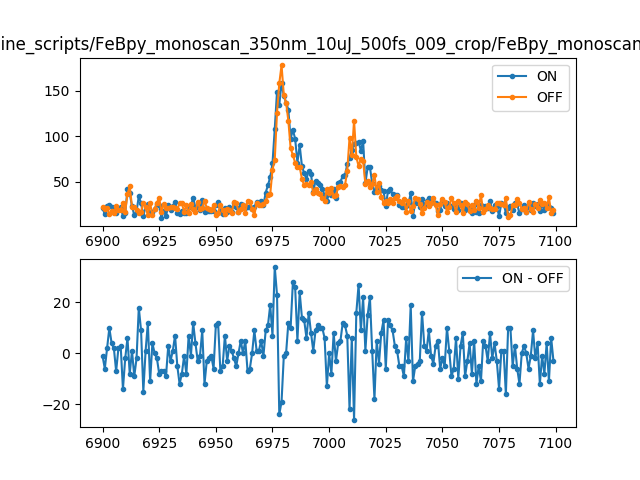

In [136]:
# Single file plot, to see whether it went ok, it would plot the last file of the loop above.
roi1 = [[200, 300], [6900, 7100]]

bin_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(JF_crop_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
#plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


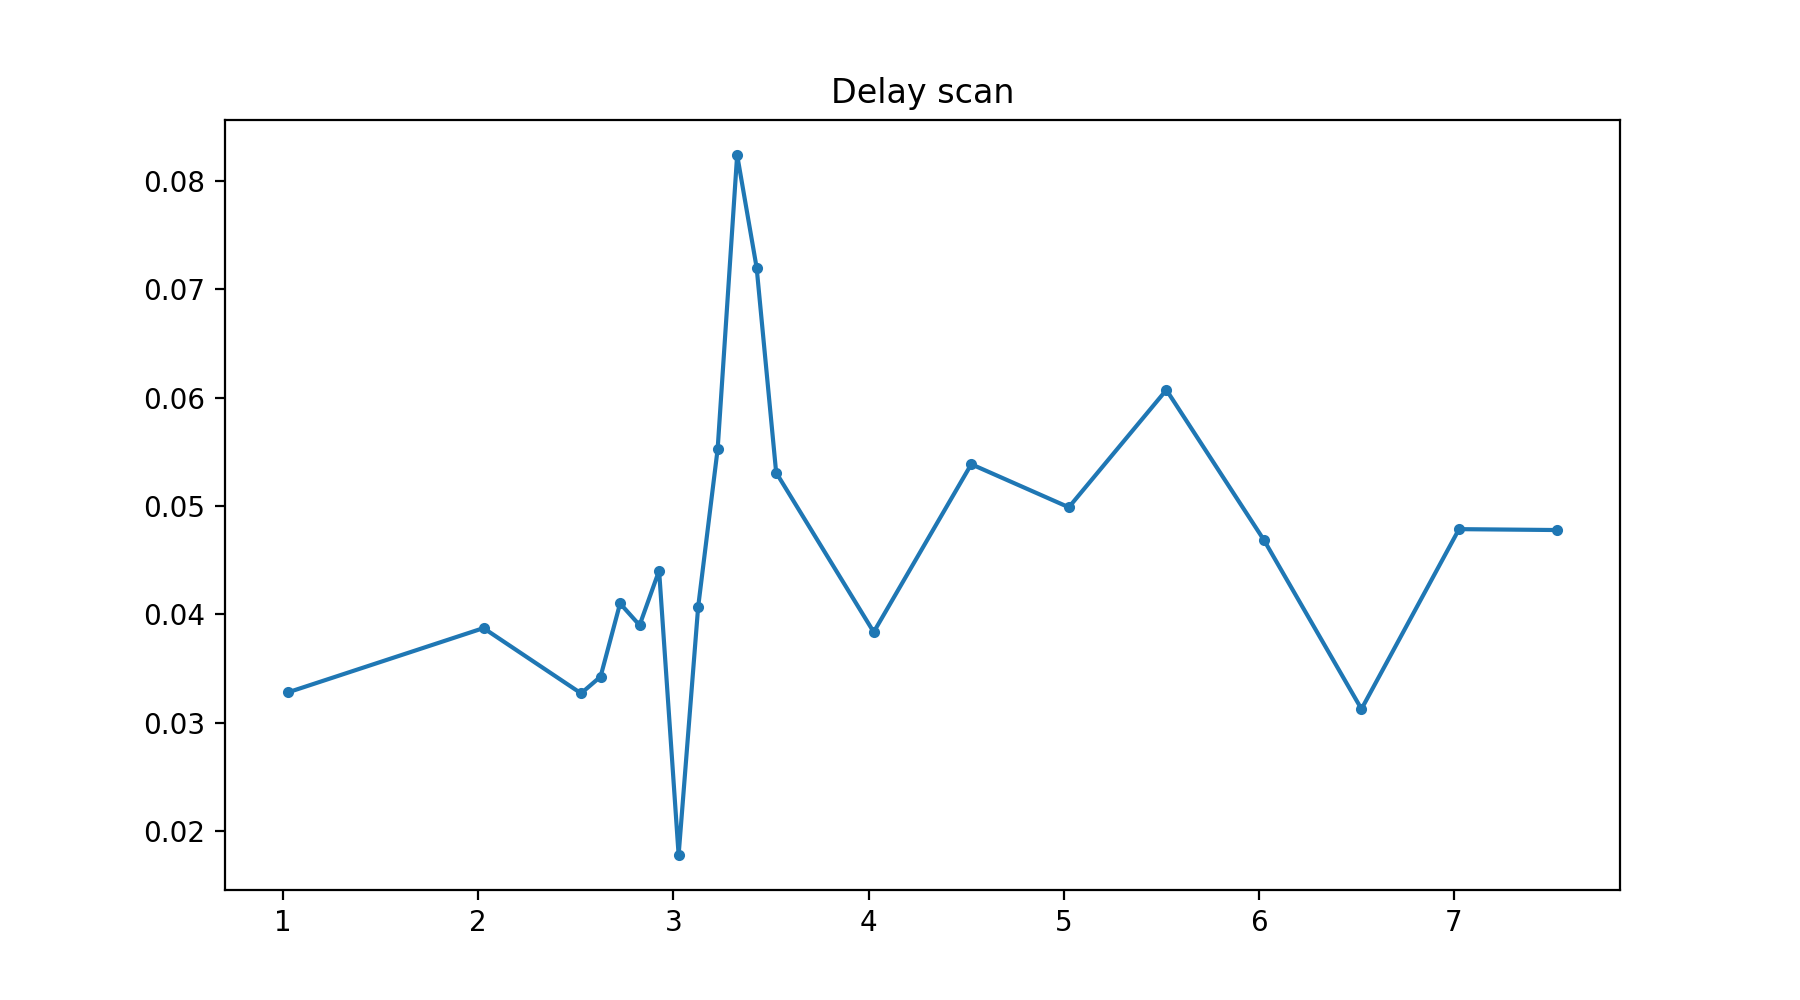

In [149]:
error_high = XAS_trans_roi1 + Error_XAS_roi1
error_low = XAS_trans_roi1 - Error_XAS_roi1

Delay_ps = (Delay_mm - 151.2)*2/(3e8*1e3*1e-12)


plt.figure(figsize=(9,5))
plt.subplots_adjust(hspace=0.5)

# plt.subplot(211)
# plt.title("XAS")
# plt.plot(Energy_eV, XAS_trans_roi1,label="Energy scan",marker='.') #This is the meaningful plot if it is a monoscan
#plt.fill_between(np.squeeze(Energy_eV), error_low, error_high, color='lightblue')
#plt.subplot(212)
plt.plot
plt.title("Delay scan")
plt.plot(Delay_ps[0:len(XAS_trans_roi1)], XAS_trans_roi1,label="Delay scan",marker='.') #This is the meaningful plot if it is a delay scan
#plt.fill_between(np.squeeze(Delay_mm), error_low, error_high, color='lightblue')
plt.show()

In [100]:
RIXS_transient_roi1

array([[ -2.,   1.,   1., ...,   3.,  -7.,  -5.],
       [ -6.,   4.,   3., ...,  -2.,   2.,   0.],
       [  2.,   2.,  -2., ...,   1.,  -7.,  10.],
       ...,
       [ -8.,  -7.,  -1., ...,   8.,   0.,  12.],
       [  1.,   2.,  -1., ...,  -2.,   9.,  10.],
       [  2.,   1., -13., ...,   0.,  -2.,   7.]], dtype=float32)

<IPython.core.display.Javascript object>


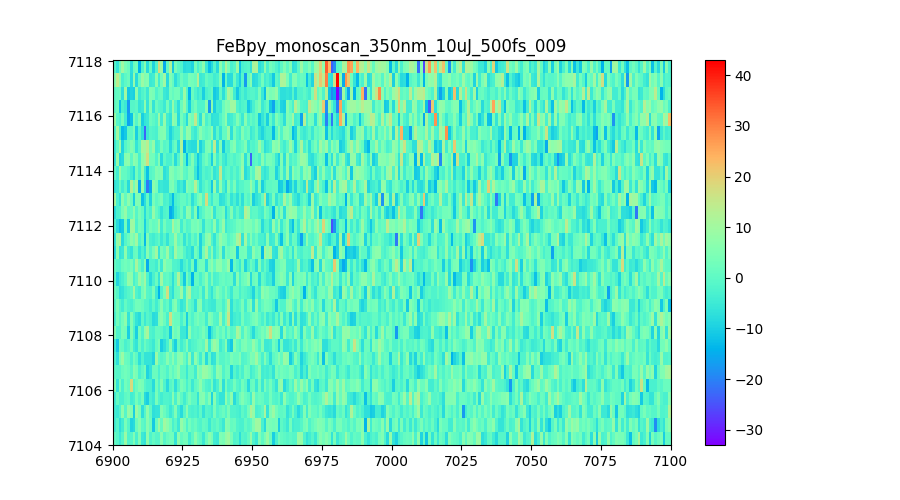

<IPython.core.display.Javascript object>


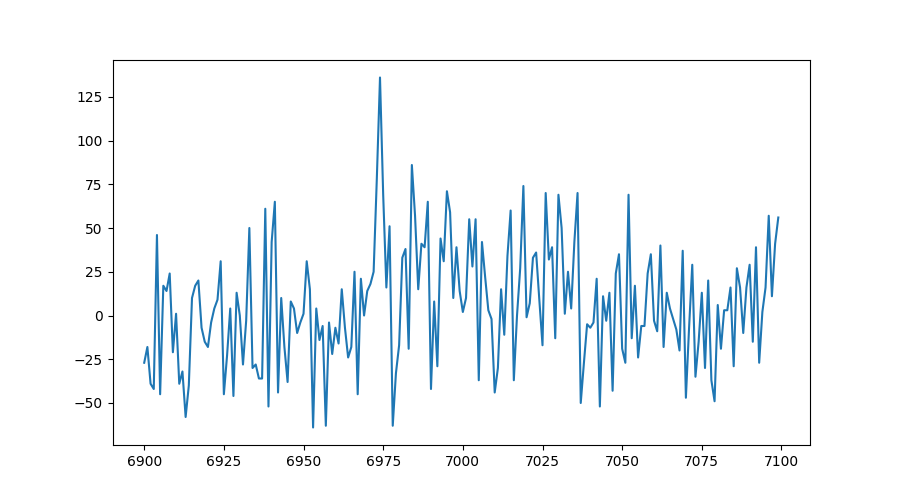

In [137]:
roi1 = [[200, 300], [6900, 7100]]

plt.figure(figsize=(9,5))
plt.imshow(RIXS_transient_roi1, extent=[roi1[1][0], roi1[1][1], Energy_eV[0], Energy_eV[-1]], aspect = 'auto', cmap = "rainbow", origin ="lower")
plt.colorbar()
plt.title(scan_name)

bin_ = 1   # change the bin size if wanted, 1 is every pixel

x_axis = np.arange(roi1[1][0], roi1[1][1])
x_axis_rebin1 = rebin_mean(x_axis)

XES_sum=sum(RIXS_transient_roi1)
XES_sum = rebin_sum(XES_sum)
plt.figure(figsize=(9,5))
plt.plot(x_axis_rebin1,XES_sum)

In [153]:
saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/data_extract/"    # dest folder (needs to exist)
fn = str(saveDir + scan_name + "_processed_XES.h5")
hf.close()

hf = h5py.File(fn, 'w')
hf.create_dataset('Position_mm', data=Delay_mm)
hf.create_dataset('Delay_ps', data=Delay_ps)

hf.create_dataset('XES', data=XAS_trans_roi1)
# 
hf.create_dataset('XES_2D_diff', data=RIXS_transient_roi1)
hf.create_dataset('XES_1D_sum', data=XES_sum)
hf.create_dataset('XES_2D_ON', data=RIXS_pumped_roi1)
hf.create_dataset('XES_2D_OFF', data=RIXS_unpumped_roi1)

hf.close()

In [134]:
Delay_mm_9 = Delay_mm
XAS_trans_roi1_9 = XAS_trans_roi1
RIXS_unpumped_roi1_9 = RIXS_unpumped_roi1
RIXS_pumped_roi1_9 = RIXS_pumped_roi1
RIXS_transient_roi1_9 = RIXS_transient_roi1

In [135]:
RIXS_unpumped_roi1 = RIXS_unpumped_roi1_3 + RIXS_unpumped_roi1_5 + RIXS_unpumped_roi1_7 + RIXS_unpumped_roi1_8 + RIXS_unpumped_roi1_9
RIXS_pumped_roi1 = RIXS_pumped_roi1_3 + RIXS_pumped_roi1_5 + RIXS_pumped_roi1_7 + RIXS_pumped_roi1_8 + RIXS_pumped_roi1_9
RIXS_transient_roi1 = RIXS_transient_roi1_3 + RIXS_transient_roi1_5 + RIXS_transient_roi1_7 + RIXS_transient_roi1_8 + RIXS_transient_roi1_9

<IPython.core.display.Javascript object>


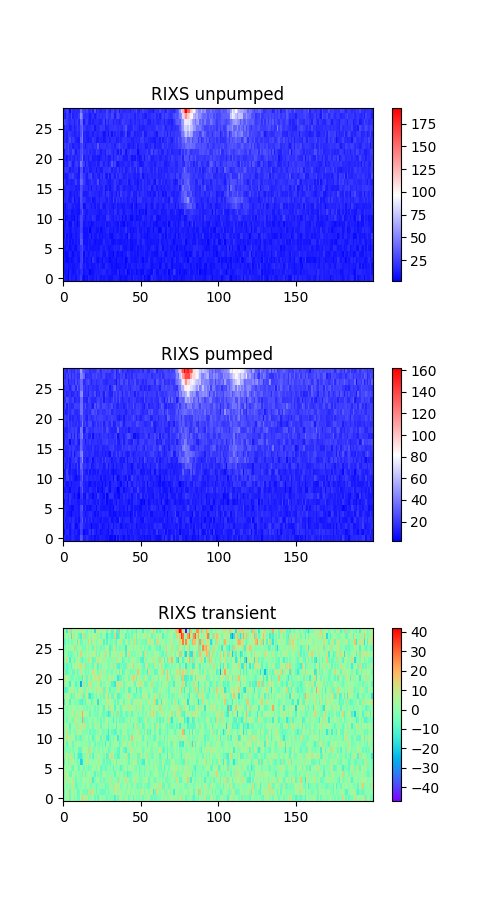

In [92]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower")
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower")#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower")#, vmin=-0.01, vmax=0.01)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

In [17]:
scan_name='CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011'

saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/data_extract/"    # dest folder (needs to exist)
fn = str(saveDir + scan_name + "_processed_XES.h5")
hf.close()

hf = h5py.File(fn, 'w')
hf.create_dataset('Delay_mm', data=Delay_mm)
#hf.create_dataset('Delay_ps', data=Delay_ps)

# hf.create_dataset('t0', data=parameters[2])
# hf.create_dataset('rise', data=parameters[3])
# hf.create_dataset('a1', data=parameters[4])
# hf.create_dataset('t1', data=parameters[5])
# hf.create_dataset('a2', data=parameters[6])
# hf.create_dataset('t2', data=parameters[7])
# # 
# hf.create_dataset('Signal_pump', data=Signal_pump)
# hf.create_dataset('err_signal_pump', data=err_signal_pump)
# hf.create_dataset('Signal_unpump', data=Signal_unpump)
# hf.create_dataset('err_signal_unpump', data=err_signal_unpump)
hf.create_dataset('XAS_trans_roi1', data=XAS_trans_roi1)
hf.create_dataset('Error_transient_roi1', data=Error_transient_roi1)
hf.close()

In [18]:
def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [23]:
# Now fit with error funciton (defined above)
delay_ps = (Delay_mm - 151.65)*2/(3e8*1e3*1e-12)

#parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 150.193, 0.05]) # [baseline, step amplitude, center, FWHM]
parameters,extras = curve_fit(biexp, delay_ps, XAS_trans_roi1, p0 = [0.1, 0.1, 0, 0.2, 1, 0.7, 0.5, 10]) # [baseline, amplitude, t0, width, a1, t1, a2, t2]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"ps")
print("Width =",np.abs(np.round(parameters[3],3)),"ps")

Position t0 = 0.177 ps
Width = 0.031 ps


<IPython.core.display.Javascript object>


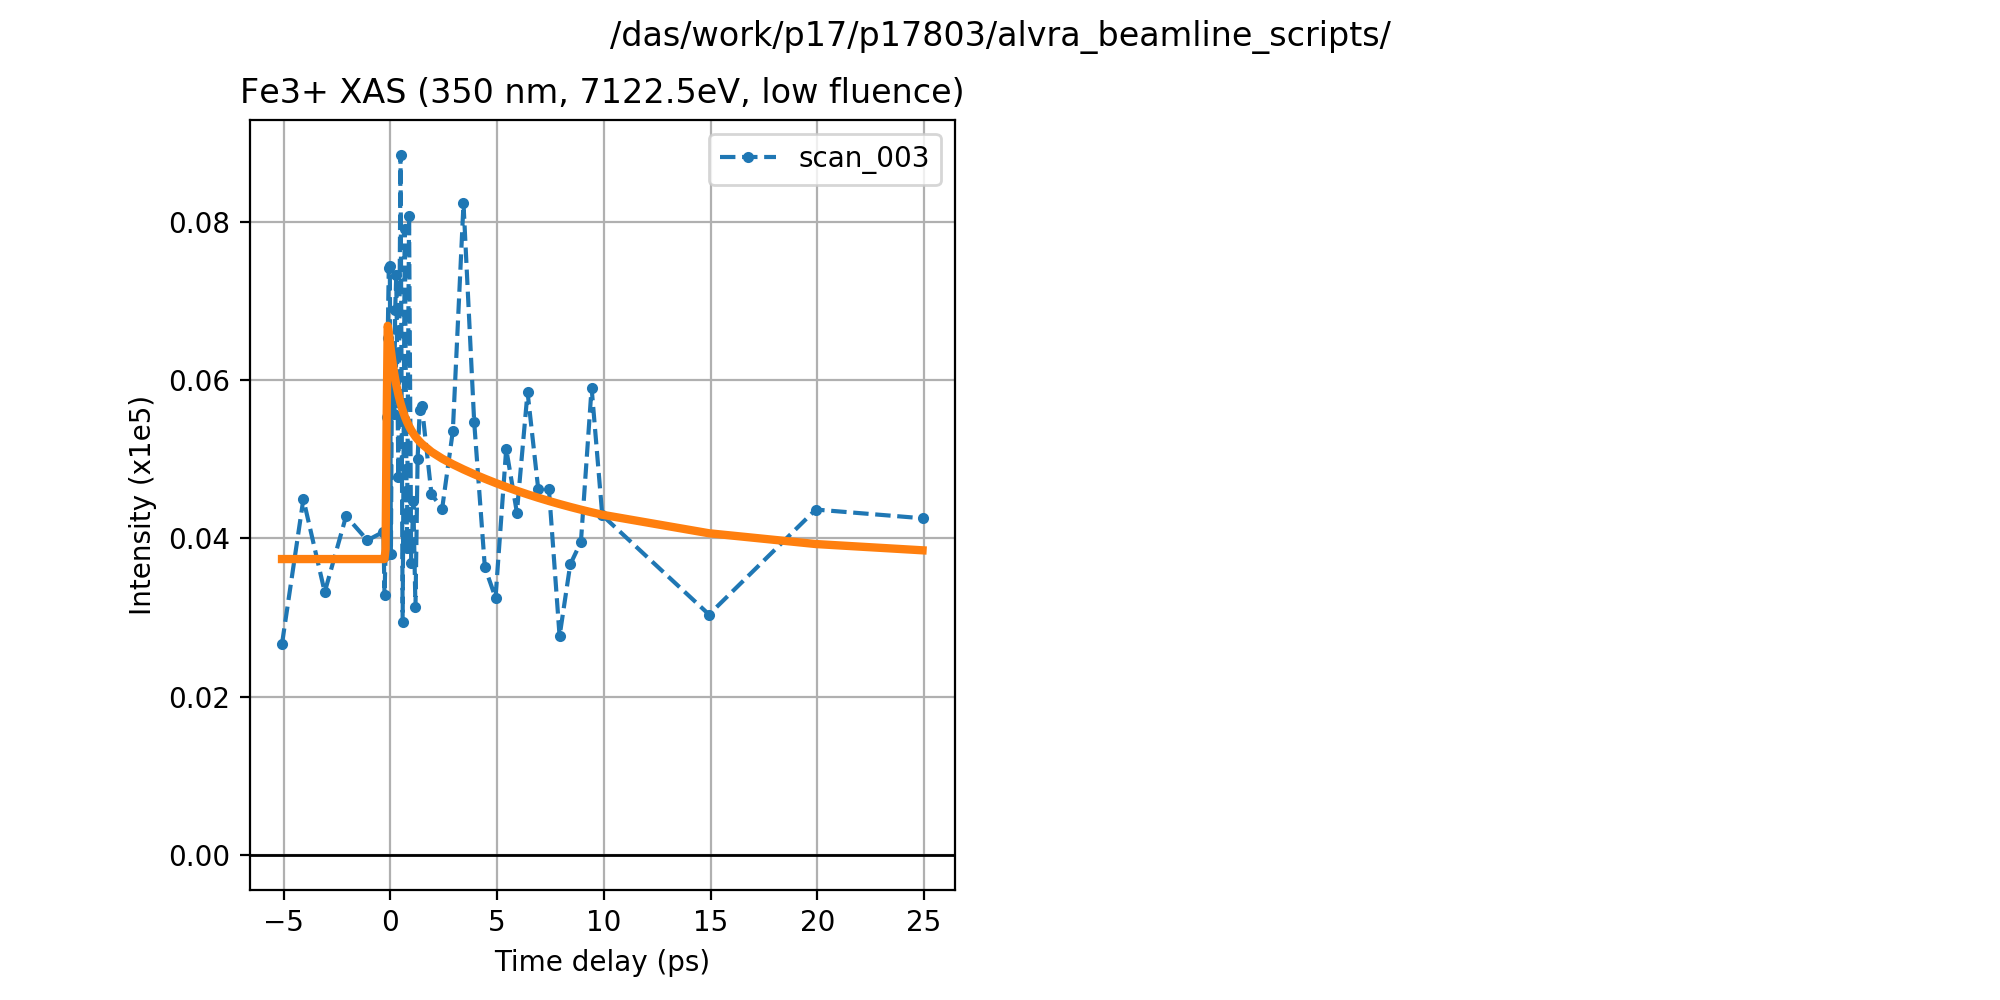

In [24]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(delay_ps, XAS_trans_roi1,'--',label="scan_003",marker='.')
#plt.errorbar(Delay_ps, Signal_norm,yerr, fmt='o',label="scan_003",marker='.')
plt.plot(delay_ps, biexp(delay_ps,*parameters),linewidth=3)
plt.grid()
plt.xlabel("Time delay (ps)")
plt.ylabel("Intensity (x1e5)")
plt.gca().set_title('Fe3+ XAS (350 nm, 7122.5eV, low fluence)')
plt.legend(loc="best")
plt.show()
